# Sitegraph Assay

A notebook to explore site graph pattern for structured data on the web.


# Intro

This instance of this notebook is exploring the INVEMAR siteagraphs.


* http://portete.invemar.org.co/chm/api/oih/expert?format=json
* http://portete.invemar.org.co/chm/api/oih/documents?format=json
* http://portete.invemar.org.co/chm/api/oih/institution?format=json
*  http://portete.invemar.org.co/chm/api/oih/vessel?format=json
* http://portete.invemar.org.co/chm/api/oih/training?format=json


## Imports

In [2]:
import urllib.request
import advertools as adv
import json
import requests
from bs4 import BeautifulSoup
import urllib.request
from pyld import jsonld
import pandas as pd
import kglab
from rdflib import Graph  #, plugin
import plotly.express as px

## Load

This section will generate:

- sg: The shape file we wish to validate with
- nc: The JSON-LD from the sgu URL.  (corrected for now for the schema.org form)
- kg: The kglab graph instance loaded with nc

In [3]:
# Note:  Make sure you load the correct SHACL shape to mate the resources in your sgu (site grap URL)

# Site graph URl
sgu = "http://portete.invemar.org.co/chm/api/oih/institution?format=json"

# shacl shape
sg = './validation/shapes/oih_organization.ttl'

In [4]:
try:
   with urllib.request.urlopen(sgu) as f:
      content = f.read().decode('utf-8')
except urllib.error.URLError as e:
   print(e.reason)

In [5]:
# nc = content.replace("\\\\/", "/")

In [6]:
namespaces = {
    "schema":  "https://schema.org/",
    "shacl":   "http://www.w3.org/ns/shacl#" ,
}

kg = kglab.KnowledgeGraph(
    name = "Schema.org shacl eval datagraph",
    base_uri = "https://example.org/id/",
    namespaces = namespaces,
)

kg.load_rdf_text(data=content, format="json-ld")

## SPARQL

Simple SPARQL test with the KG to see what the elements look like.  Here we are looking for rdf:type schema:Organization so be sure
to make modifications if you are looking for other types.

In [7]:
sparql = """
PREFIX schema: <https://schema.org/>
SELECT ?s
  WHERE {
    ?s a schema:Organization
  }
"""

df0 = kg.query_as_df(sparql)
df = df0.to_pandas()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s       148 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB


## Frame

A useful exploration is to frame out some of the elements from the site graph and simply inspect them.  This can also be a good method to process all the site graph entries for things like spatial, citation or other views.

More information on framing can be found at the [JSON-LD Framing documentation](https://json-ld.org/spec/latest/json-ld-framing/#framing-flags).

The elN element represents the Nth item in the resulting array of frame matches.  In some cases in the graph pattern this can result in unexpected matches.  For example the ItemList itself could be multi-typed to include CreativeWork and then any frame looking for that type might match the the entire ItemList node.  


In [8]:
myframe =  {
    "@context":{"@vocab": "https://schema.org/"}, 
    "@type": "Organization",
}

In [9]:
jld = json.loads(content)
myframed = jsonld.frame(jld, myframe)
# print(myframed)  # to see all the output (will be large typically)

elN = myframed['@graph'][4]  # see the 4 array element

In [10]:
json_formatted_str = json.dumps(elN, indent=4)
print(json_formatted_str)

{
    "@id": "http://portete.invemar.org.co/chm/api/oih/institution#0829ec6b65f126461afea1bab0a8fd2966129f3d52b1d88309f1a1b727f88c74",
    "@type": "Organization",
    "address": {
        "@id": "_:b207",
        "@type": "PostalAddress",
        "addressLocality": "Colombia",
        "streetAddress": "Carrera 45A#104B-16 Bogota, Bogota, 111111 Colombia"
    },
    "name": "CO2CERO",
    "thumbnailUrl": "/static/main/index/images/inst-default.png",
    "url": "https://oceanexpert.org/institution/21549"
}


## SHACL Validation Results

In [11]:
conforms, report_graph, report_text = kg.validate(
    shacl_graph=sg,
    shacl_graph_format="ttl"
)

In [12]:
sparql = """
SELECT ?path ?value ?constraint ?severity ?message ?id ?focus
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:resultSeverity ?severity .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""

pdf = report_graph.query_as_df(sparql)
df = pdf.to_pandas()
ctst = pd.crosstab(df['message'], df['severity'], margins = True, margins_name = 'Subtotals')
ctst

severity,sh:Violation,sh:Warning,Subtotals
message,,,
A resource should include a description,148,0,148
A resource should include a url,2,0,2
An organization should include an address,0,2,2
Subtotals,150,2,152


## Heatmap

Exploring ways to plot the the SHACL results.

<AxesSubplot:xlabel='severity', ylabel='message'>

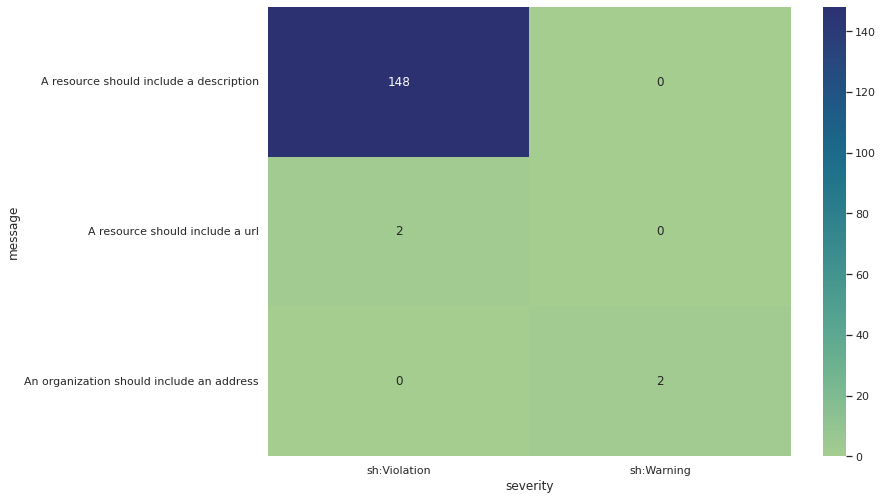

In [13]:
import seaborn as sns

ct = pd.crosstab(df['message'], df['severity'])

cmap = sns.cm.crest
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(ct, annot=True, fmt=".0f", cmap = cmap)

In [14]:
# TODO export to parquet and or CSV
# df.to_parquet("./output/eco_opentopo_SHACL.parquet")
df.to_csv("./validation/output/invemar_OrgSHACL.csv")